## Fine-Tuning CLIP Models

In this notebook, we will look at how you can fine-tune a CLIP model for image classification.

Note: before you start, ensure your runtime is set to GPU. If you're unsure on how to do that, visit this [article](https://www.marqo.ai/blog/getting-started-with-google-colab-a-beginners-guide).

### **1. Install Relevant Libraries**

We first install relevant modules

In [396]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2

IMAGE_DIR = 'real_pokemon_data/images'

We will be using `openai-clip` to define our base CLIP model and utilising `datasets` provided by Hugging Face. The library `torch` will be used to facilitate model loading, device management, tensor manipulation, and inference. Finally, `tqdm` is used to track the progress of the fine-tuning.

Now we've installed the libraries needed to fine-tune, we must obtain a dataset to perform this fine-tuning.

### **2. Load a Dataset**

To perform fine-tuning, we will use a small image classification dataset. We’ll use the `ceyda/fashion-products-small` dataset which is a collection of fashion products.

In [397]:
# Function to load JSON data
def load_json(json_path: str):
    """
    Load a JSON file.
    
    Args:
        json_path (str): Path to the JSON file.
        
    Returns:
        List[Dict]: Loaded JSON data as a list of dictionaries.
    """
    with open(json_path, 'r') as file:
        return json.load(file)

# Load the train, validation, and test JSONs
train_data = load_json('real_pokemon_data/train/dataset.json')
val_data = load_json('real_pokemon_data/validation/dataset.json')
test_data = load_json('real_pokemon_data/test/dataset.json')

print([len(x) for x in [train_data, val_data, test_data]])

[840, 42, 87]


We see that we have `filename`, `link`, `id`, `masterCategory`, `gender`, `subCategory` and `image`. Let's print the first example from this dataset to see what these features mean:

In [398]:
entry = train_data[5]['conversations'][1]['desc']
entry

'It has tremendous psychic power, but it dislikes conflict. It’s also able to predict the future based on the movement of the stars.'

In [399]:
dataset = train_data

### **3. Load CLIP Model and Preprocessing**

The CLIP model (`ViT-L/14`) and its preprocessing function are loaded. The model is moved to the appropriate device (GPU if available, otherwise CPU).

In [400]:
# Stops output in Colab. Remove this if you wish.
# %%capture

import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-L/14", jit=False)
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


Let's take a look at how well our base CLIP model performs image classification on this dataset.

This code uses the CLIP model to classify three example images from our dataset by comparing their visual features with textual descriptions of subcategories. It processes and normalizes the features of the images and subcategory texts, calculates their similarity, and predicts the subcategory for each image. Finally, it visualizes the images alongside their predicted and actual subcategories in a plot.

In [401]:
# import os
# import cv2
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import clip
# import matplotlib.pyplot as plt

# def preprocess_image(image_path, target_size=(224, 224)):
#     # Read the image in BGR format
#     # print(image_path)
#     image = cv2.imread(image_path)
    
#     # Resize the image to the target size (e.g., 224x224)
#     image = cv2.resize(image, target_size)
    
#     # Convert the image from BGR to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     # Define the transformation pipeline (same as self.transform)
#     transform = transforms.Compose([
#         transforms.ToTensor(),  # Convert to a tensor
#         # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
#     ])
    
#     # Apply the transformations
#     image_tensor = transform(image)
    
#     return image_tensor


# # Define the dataset class for batch processing
# class PokemonDataset(Dataset):
#     def __init__(self, dataset, subcategories, transform=None):
#         self.dataset = dataset
#         self.subcategories = subcategories
#         # self.transform = transforms.Compose([
#         #     transforms.Resize((224, 224)),
#         #     transforms.ToTensor(),
#         #     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#         # ])

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         example = self.dataset[idx]
#         image_path = os.path.join(IMAGE_DIR, example['image'])
        
#         # Preprocess the image
#         image_tensor = preprocess_image(image_path)
#         # if self.transform:
#         #     image_tensor = self.transform(image_tensor)
        
#         # Get subcategory (text for the image)
#         subcategory = example['conversations'][1]['value']
#         subcategory2 = example['conversations'][1]['value2']
#         description = example['conversations'][1]['desc']
#         label = self.subcategories.index(subcategory)
#         label2 = self.subcategories.index(subcategory2) if subcategory2 is not None else 999
        
#         return image_tensor, label, label2, description

# # Load your dataset (replace this with your actual dataset)
# # Assuming 'dataset' is a list of dictionaries and 'subcategories' is a list of unique types.
# subcategories = list(set(example['conversations'][1]['value'] for example in dataset))

# # Initialize the dataset and DataLoader
# pokemon_dataset = PokemonDataset(dataset, subcategories)
# dataloader = DataLoader(pokemon_dataset, batch_size=3, shuffle=True)

# # Initialize CLIP model and preprocessing
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-L/14", device=device)

# # Preprocess the text (convert the subcategories to CLIP's tokenized format)
# text_inputs = torch.cat([clip.tokenize(f"A photo of a {c} pokemon.") for c in subcategories]).to(device)

# # Create a figure with subplots
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Loop through the DataLoader to process images in batches
# for i, (images, subcategories_batch, subcategories_batch2, descriptions_batch) in enumerate(dataloader):
#     images = images.to(device)  # Move images to the correct device
    
#     # Combine subcategories with descriptions for batch text inputs
#     batch_texts = [
#         f"A photo of a {subcategories[s]}. Description: {desc}"
#         for s, desc in zip(subcategories_batch, descriptions_batch)
#     ]
#     batch_text_inputs = torch.cat([clip.tokenize(text) for text in batch_texts]).to(device)
    
#     # Encode text features for the batch
#     with torch.no_grad():
#         text_features = model.encode_text(batch_text_inputs)
#         image_features = model.encode_image(images)
    
#     # Normalize features
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)
    
#     # Calculate similarity between image and enriched text features
#     similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
#     # Display predictions
#     for j in range(images.size(0)):
#         similarity_scores = similarity[j]
#         values, indices = similarity_scores.topk(1)
#         predicted_subcategory = subcategories[indices[0]]

#         # Display the image
#         axes[j].imshow(images[j].cpu().permute(1, 2, 0).numpy())
#         axes[j].set_title(f"Predicted: {predicted_subcategory}, Actual: {subcategories[subcategories_batch[j]]}")
#         axes[j].axis('off')
    
#     if i == 0:  # Stop after first batch
#         break


# # Show the plot
# plt.tight_layout()
# plt.show()


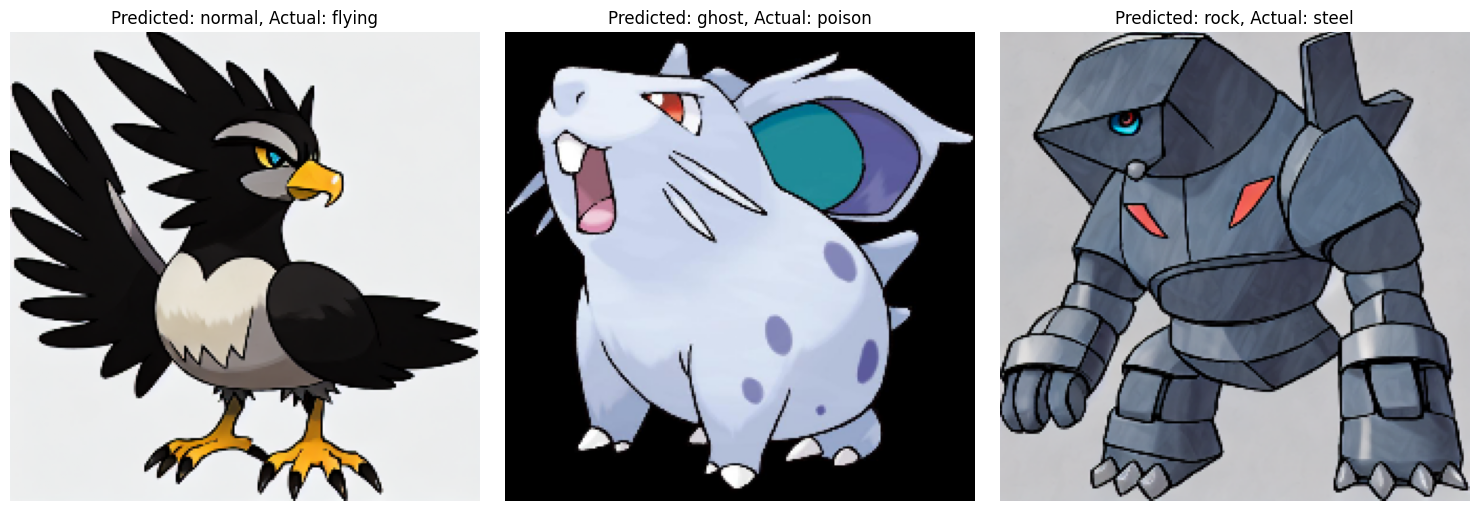

In [402]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import clip
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    # Read the image in BGR format
    # print(image_path)
    image = cv2.imread(image_path)
    
    # Resize the image to the target size (e.g., 224x224)
    image = cv2.resize(image, target_size)
    
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the transformation pipeline (same as self.transform)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to a tensor
        # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
    ])
    
    # Apply the transformations
    image_tensor = transform(image)
    
    return image_tensor


# Define the dataset class for batch processing
class PokemonDataset(Dataset):
    def __init__(self, dataset, subcategories, transform=None):
        self.dataset = dataset
        self.subcategories = subcategories
        # self.transform = transforms.Compose([
        #     transforms.Resize((224, 224)),
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        # ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image_path = os.path.join(IMAGE_DIR, example['image'])
        
        # Preprocess the image
        image_tensor = preprocess_image(image_path)
        # if self.transform:
        #     image_tensor = self.transform(image_tensor)
        
        # Get subcategory (text for the image)
        subcategory = example['conversations'][1]['value']
        label = self.subcategories.index(subcategory)
        
        return image_tensor, label

# Load your dataset (replace this with your actual dataset)
# Assuming 'dataset' is a list of dictionaries and 'subcategories' is a list of unique types.
subcategories = list(set(example['conversations'][1]['value'] for example in dataset))

# Initialize the dataset and DataLoader
pokemon_dataset = PokemonDataset(dataset, subcategories)
dataloader = DataLoader(pokemon_dataset, batch_size=3, shuffle=True)

# Initialize CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

# Preprocess the text (convert the subcategories to CLIP's tokenized format)
text_inputs = torch.cat([clip.tokenize(f"A photo of a {c} pokemon.") for c in subcategories]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the DataLoader to process images in batches
for i, (images, subcategories_batch) in enumerate(dataloader):
    images = images.to(device)  # Move images to the correct device
    text_features = model.encode_text(text_inputs)  # Get text features for subcategories

    # Preprocess the images and run them through CLIP
    with torch.no_grad():
        image_features = model.encode_image(images)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    # Display images and predictions
    for j in range(images.size(0)):
        similarity_scores = similarity[j]
        values, indices = similarity_scores.topk(1)
        predicted_subcategory = subcategories[indices[0]]

        # Get the actual subcategory from the batch
        actual_subcategory = subcategories_batch[j]

        # Display the image in the subplot
        axes[j].imshow(images[j].cpu().permute(1, 2, 0).numpy())  # Convert back to HxWxC for plotting
        axes[j].set_title(f"Predicted: {predicted_subcategory}, Actual: {subcategories[actual_subcategory]}")
        axes[j].axis('off')

    # Exit after displaying 3 images
    if i == 0:
        break

# Show the plot
plt.tight_layout()
plt.show()


In [403]:
# import pickle
# with open('pokemon_descriptions_v2.pkl', 'rb') as f:
#     lol = pickle.load(f)
# lol

As we can see for the three images, our base CLIP model does not perform very well. It only identifies one of the three images correctly.

Let's set up the process for fine-tuning our CLIP model to improve these predictions.

### **4. Processing the Dataset**

First, we must split our dataset into training and validation sets. This step is crucial because it allows us to evaluate the performance of our machine learning model on unseen data, ensuring that the model generalizes well to new, real-world data rather than just the data it was trained on.

We take 80% of the original dataset to train our model and the remaining 20% as the validation data.

In [404]:
# from torch.utils.data import random_split

# # Split dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Next, we create a custom dataset class:

In [405]:
# from torchvision import transforms
# from torch.utils.data import Dataset

# # Define a custom dataset class
# class FashionDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#         ])

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         image = item['image']
#         subcategory = item['subCategory']
#         label = subcategories.index(subcategory)
#         return self.transform(image), label

Let's break this down:

* **`__init__` method**: Initializes the dataset object with data and sets up a series of transformations to preprocess the images. The transformations include resizing the images to 224x224 pixels, converting them to tensors, and normalizing them with specific mean and standard deviation values.
* **`__len__` method**: Returns the number of samples in the dataset.
* **`__getitem__` method**: Retrieves an image and its corresponding subcategory from the dataset. The image is transformed using the predefined transformations, and the subcategory is converted to a label by finding its index in the subcategories list.

Next, we create DataLoaders:

In [406]:
from torch.utils.data import DataLoader


# pokemon_dataset = PokemonDataset(dataset, subcategories)
# dataloader = DataLoader(pokemon_dataset, batch_size=3, shuffle=True)

# Create DataLoader for training and validation sets
train_loader = DataLoader(PokemonDataset(train_data, subcategories), batch_size=3, shuffle=True)
val_loader = DataLoader(PokemonDataset(val_data, subcategories), batch_size=3, shuffle=False)

Here,
* `train_loader`: A DataLoader for the training set, with a batch size of 32 and shuffling enabled to randomize the order of samples.
* `val_loader`: A DataLoader for the validation set, with a batch size of 32 and shuffling disabled to maintain the order of samples.

Next, we modify the model for fine-tuning:

In [407]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

### **5. Define Loss Function and Optimizer**

We define as follows:

In [408]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import optim

num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-3)

# Number of epochs for training
num_epochs = 5

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    avg_train_loss = running_loss / len(train_loader)  # Calculate average loss for the epoch
    train_losses.append(avg_train_loss)  # Store the training loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    val_accuracy = 100 * correct / total  # Calculate validation accuracy
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch
    print(f'Validation Accuracy: {val_accuracy:.2f}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/5, Loss: 1.8807: 100%|██████████| 280/280 [00:07<00:00, 39.82it/s]


Epoch [1/5], Loss: 1.8807
Validation Accuracy: 52.38%


Epoch 2/5, Loss: 0.9624: 100%|██████████| 280/280 [00:06<00:00, 40.13it/s]


Epoch [2/5], Loss: 0.9624
Validation Accuracy: 47.62%


Epoch 3/5, Loss: 0.7282: 100%|██████████| 280/280 [00:06<00:00, 40.08it/s]


Epoch [3/5], Loss: 0.7282
Validation Accuracy: 59.52%


Epoch 4/5, Loss: 0.5764: 100%|██████████| 280/280 [00:06<00:00, 40.37it/s]


Epoch [4/5], Loss: 0.5764
Validation Accuracy: 54.76%


Epoch 5/5, Loss: 0.4631: 100%|██████████| 280/280 [00:06<00:00, 40.42it/s]


Epoch [5/5], Loss: 0.4631
Validation Accuracy: 52.38%


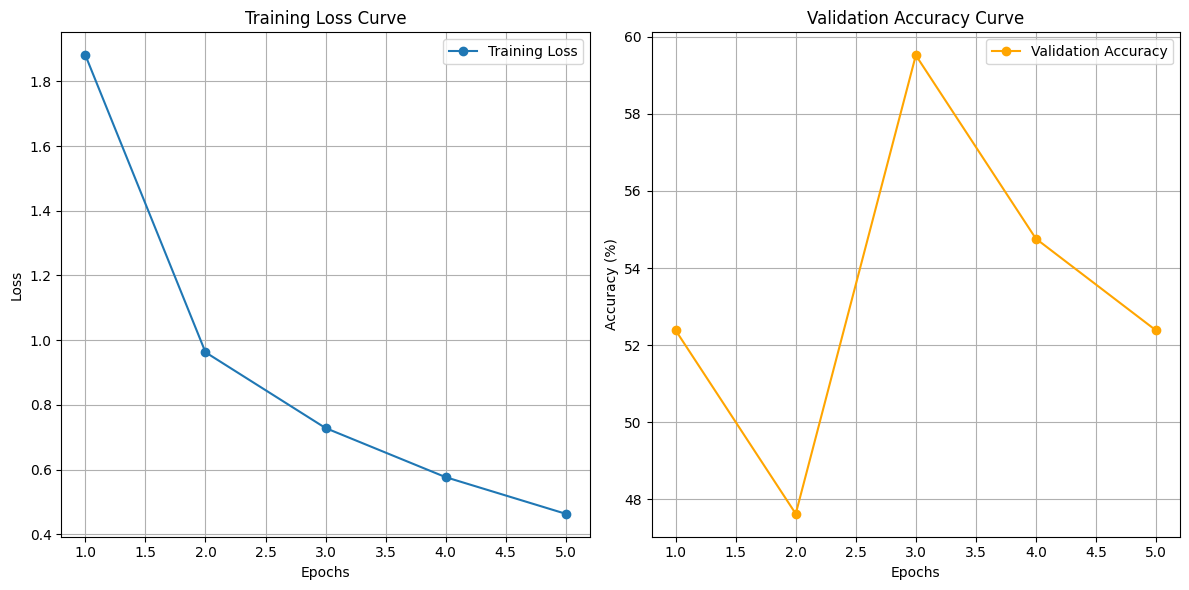

In [409]:
# Plot training loss and validation accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_4181565/2682051884.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('clip_finetuned.pth'))


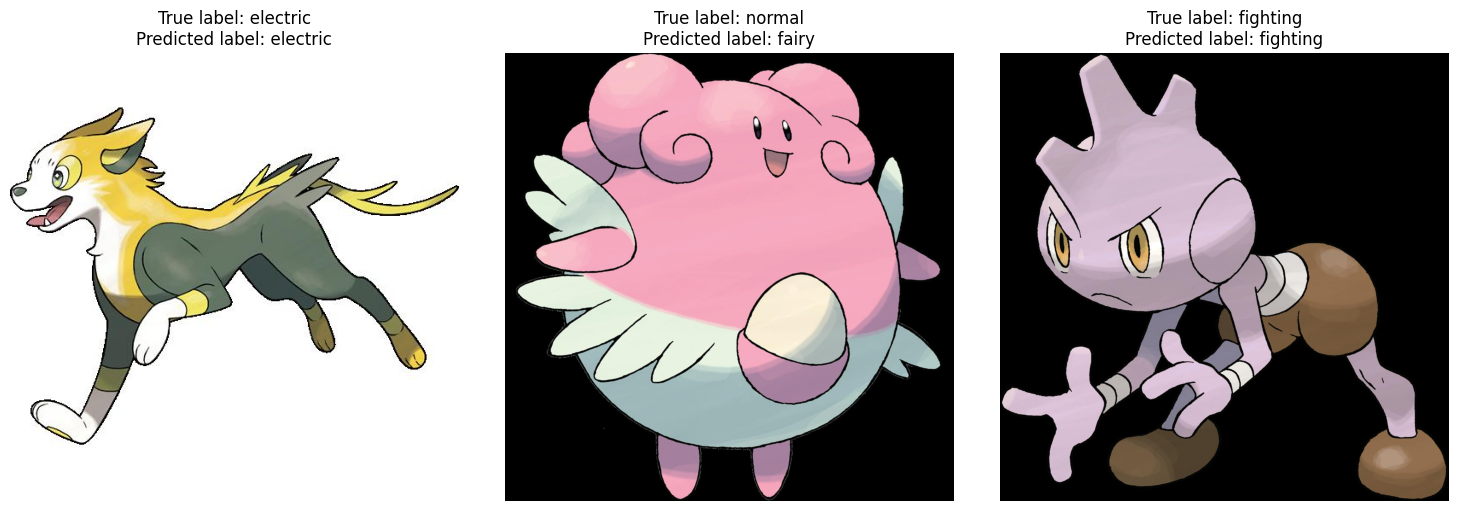

In [414]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Define the indices for the three images
indices = [0, 2, 12]

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    example = dataset[idx]
    image_path = os.path.join(IMAGE_DIR, example['image'])
    
    # Preprocess the image
    image_tensor = preprocess_image(image_path).unsqueeze(0).cuda()
    
    # Get subcategory (text for the image)
    subcategory = example['conversations'][1]['value']
    true_label = subcategories.index(subcategory)
    
    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # Display the image in the subplot
    axes[i].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'True label: {subcategories[true_label]}\nPredicted label: {predicted_label}')
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [415]:
import torch
import os
import cv2
import matplotlib.pyplot as plt

def evaluate_model(dataset, model, subcategories, use_clip_style=False):
    # Variables to keep track of correct predictions and total samples
    correct_predictions = 0
    total_samples = 0

    # Precompute text features for all subcategories (only for CLIP-style models)
    if use_clip_style:
        text_inputs = torch.cat([clip.tokenize(f"A photo of a {subcategory} pokemon.") for subcategory in subcategories]).cuda()
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)

    # Iterate over all data in the dataset
    for example in dataset:
        image_path = os.path.join(IMAGE_DIR, example['image'])

        # Preprocess the image
        image_tensor = preprocess_image(image_path).unsqueeze(0).cuda()

        # Get the true subcategory labels
        subcategory = example['conversations'][1]['value']
        other_cat = example['conversations'][1]['value2']
        true_labels = [subcategory, 
                    #    other_cat,
                       ]

        # Perform inference
        with torch.no_grad():
            if use_clip_style:
                # Use CLIP-style similarity scoring
                image_features = model.encode_image(image_tensor)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                # Calculate similarity scores
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                predicted_label_idx = similarity.argmax(dim=-1).item()
            else:
                # Use logits from fine-tuned model
                logits = model(image_tensor)
                predicted_label_idx = logits.argmax(dim=-1).item()

        predicted_label = subcategories[predicted_label_idx]

        # Increment total samples
        total_samples += 1

        # Check if predicted label matches one of the true labels
        if predicted_label in true_labels:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_samples * 100
    print(f"Accuracy: {accuracy:.2f}%")



# Evaluate on the training set using original CLIP model
# print("Training Set Evaluation (Original Model):")
# evaluate_model(train_data, model, subcategories=subcategories, use_clip_style=True)
# print("\nValidation Set Evaluation (Original Model):")
# evaluate_model(val_data, model, subcategories=subcategories, use_clip_style=True)
# print("\nTest Set Evaluation (Original Model):")
# evaluate_model(test_data, model, subcategories=subcategories, use_clip_style=True)

# Evaluate on the training set using fine-tuned model
# print("\nTraining Set Evaluation (Fine-Tuned Model):")
# evaluate_model(train_data, model_ft, subcategories=subcategories, use_clip_style=False)
# print("\nValidation Set Evaluation (Fine-Tuned Model):")
# evaluate_model(val_data, model_ft, subcategories=subcategories, use_clip_style=False)
# print("\nTest Set Evaluation (Fine-Tuned Model):")
evaluate_model(test_data, model_ft, subcategories=subcategories, use_clip_style=False)



Accuracy: 62.07%


In [412]:
len(train_data)

840

In [413]:
# roc_auc = calculate_roc_auc(model_ft, dataloader, device)
# roc_auc